# **WOTR Dataset Download**

In [1]:
#Setup Gdrive file download extention 
!pip install gdown

In [2]:
# !gdown --id <File ID>
!gdown --id 11Idy50HhzedOXxpxYuoecfqMNHGcxVfj

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=11Idy50HhzedOXxpxYuoecfqMNHGcxVfj
From (redirected): https://drive.google.com/uc?id=11Idy50HhzedOXxpxYuoecfqMNHGcxVfj&confirm=t&uuid=ffeb2a49-6f94-4e3e-8aa3-c8ff1c08a0d8
To: /kaggle/working/WOTR.zip
100%|███████████████████████████████████████| 4.24G/4.24G [00:41<00:00, 102MB/s]


In [3]:
!unzip /kaggle/working/WOTR.zip

Archive:  /kaggle/working/WOTR.zip
   creating: WOTR/
   creating: WOTR/Annotations/
  inflating: WOTR/Annotations/10000001.xml  
  inflating: WOTR/Annotations/10000002.xml  
  inflating: WOTR/Annotations/10000003.xml  
  inflating: WOTR/Annotations/10000004.xml  
  inflating: WOTR/Annotations/10000006.xml  
  inflating: WOTR/Annotations/10000007.xml  
  inflating: WOTR/Annotations/10000008.xml  
  inflating: WOTR/Annotations/10000010.xml  
  inflating: WOTR/Annotations/10000012.xml  
  inflating: WOTR/Annotations/10000014.xml  
  inflating: WOTR/Annotations/10000015.xml  
  inflating: WOTR/Annotations/10000016.xml  
  inflating: WOTR/Annotations/10000017.xml  
  inflating: WOTR/Annotations/10000019.xml  
  inflating: WOTR/Annotations/10000021.xml  
  inflating: WOTR/Annotations/10000022.xml  
  inflating: WOTR/Annotations/10000026.xml  
  inflating: WOTR/Annotations/10000027.xml  
  inflating: WOTR/Annotations/10000028.xml  
  inflating: WOTR/Annotations/10000029.xml  
  inflating: WO

# **Converting From Voc to YOLO Format**

In [1]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [5]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [6]:
print(extract_info_from_xml('/kaggle/working/WOTR/Annotations/30013924.xml'))

{'bboxes': [{'class': 'pole', 'xmin': 70, 'ymin': 199, 'xmax': 87, 'ymax': 332}, {'class': 'tree', 'xmin': 289, 'ymin': 249, 'xmax': 304, 'ymax': 329}, {'class': 'tree', 'xmin': 395, 'ymin': 265, 'xmax': 409, 'ymax': 331}, {'class': 'pole', 'xmin': 505, 'ymin': 230, 'xmax': 515, 'ymax': 328}, {'class': 'pole', 'xmin': 526, 'ymin': 230, 'xmax': 536, 'ymax': 327}, {'class': 'pole', 'xmin': 546, 'ymin': 133, 'xmax': 559, 'ymax': 325}, {'class': 'car', 'xmin': 812, 'ymin': 303, 'xmax': 860, 'ymax': 326}, {'class': 'car', 'xmin': 763, 'ymin': 303, 'xmax': 806, 'ymax': 328}, {'class': 'car', 'xmin': 722, 'ymin': 302, 'xmax': 767, 'ymax': 329}, {'class': 'tree', 'xmin': 646, 'ymin': 272, 'xmax': 657, 'ymax': 312}, {'class': 'red_light', 'xmin': 690, 'ymin': 213, 'xmax': 700, 'ymax': 238}, {'class': 'green_light', 'xmin': 699, 'ymin': 213, 'xmax': 712, 'ymax': 239}, {'class': 'crosswalk', 'xmin': 565, 'ymin': 324, 'xmax': 876, 'ymax': 337}, {'class': 'crosswalk', 'xmin': 1, 'ymin': 331, 'xmax'

In [ ]:
#import shutil
#shutil.rmtree('/kaggle/working/WOTR/annotations')

In [7]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {'tree' : 0,'red_light' : 1,'green_light' : 2,'crosswalk' : 3,
                            'tactile_paving' : 4,'sign' : 5, 'person' : 6, 'bicycle' : 7,
                            'bus' : 8, 'truck' : 9, 'car' : 10,'motorcycle' : 11,
                            'reflective_cone' : 12, 'ashcan' : 13, 'warning_column' : 14,
                            'roadblock' : 15, 'pole' : 16,'dog' : 17, 'tricycle' : 18,
                            'fire_hydrant' : 19,'blind_road' : 20}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(ann):
    info_dict = extract_info_from_xml(ann)
    print_buffer = []
    
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ",str(b["class"]), class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        #if class_id==20:
        #   print(ann)
    # Name of the file which we have to save 
    save_file_name = os.path.join(ann.replace("Annotations","annotations").replace("xml", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [8]:
os.mkdir('/kaggle/working/WOTR/annotations')

In [9]:
# Get the annotations
annotations = [os.path.join('/kaggle/working/WOTR/Annotations', x) for x in os.listdir('/kaggle/working/WOTR/Annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    #info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(ann)
annotations = [os.path.join('/kaggle/working/WOTR/annotations', x) for x in os.listdir('/kaggle/working/WOTR/annotations') if x[-3:] == "txt"]

100%|██████████| 13928/13928 [00:05<00:00, 2440.73it/s]


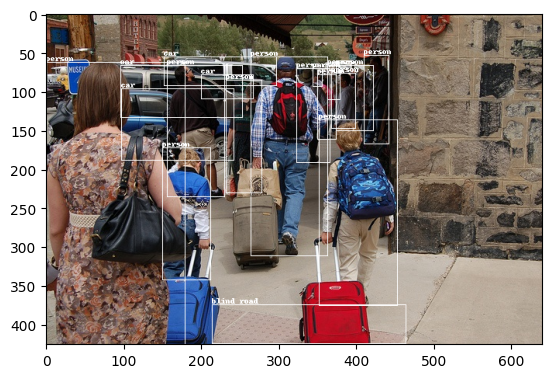

In [10]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
#annotation_file = random.choice(annotations)
#annotation_file = '/kaggle/working/WOTR/annotations/30013924.txt'
annotation_file = '/kaggle/working/WOTR/annotations/10000087.txt'
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "JPEGImages").replace("txt", "jpg")
#print(annotation_file)
#print(image_file)
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

# **Partitioning The Dataset**

In [11]:
f = open("/kaggle/working/WOTR/ImageSets/Main/train.txt", "r")
# Read images and annotations
train_images = [os.path.join('/kaggle/working/WOTR/JPEGImages', x.strip()+'.jpg') for x in f]
f = open("/kaggle/working/WOTR/ImageSets/Main/train.txt", "r")
train_annotations = [os.path.join('/kaggle/working/WOTR/annotations', x.strip()+'.txt') for x in f]
  

In [12]:
f = open("/kaggle/working/WOTR/ImageSets/Main/val.txt", "r")
# Read images and annotations
val_images = [os.path.join('/kaggle/working/WOTR/JPEGImages', x.strip()+'.jpg') for x in f]
f = open("/kaggle/working/WOTR/ImageSets/Main/val.txt", "r")
val_annotations = [os.path.join('/kaggle/working/WOTR/annotations', x.strip()+'.txt') for x in f]

In [13]:
f = open("/kaggle/working/WOTR/ImageSets/Main/test.txt", "r")
# Read images and annotations
test_images = [os.path.join('/kaggle/working/WOTR/JPEGImages', x.strip()+'.jpg') for x in f]
f = open("/kaggle/working/WOTR/ImageSets/Main/test.txt", "r")
test_annotations = [os.path.join('/kaggle/working/WOTR/annotations', x.strip()+'.txt') for x in f]

In [ ]:
#print(val_images)

# Read images and annotations
images = [os.path.join('/kaggle/working/WOTR/JPEGImages', x) for x in os.listdir('/kaggle/working/WOTR/JPEGImages')]
annotations = [os.path.join('/kaggle/working/WOTR/annotations', x) for x in os.listdir('/kaggle/working/WOTR/annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [14]:
os.mkdir('/kaggle/working/images')
os.mkdir('/kaggle/working/labels')
os.mkdir('images/train')
os.mkdir('images/val')
os.mkdir('images/test')
os.mkdir('labels/train')
os.mkdir('labels/val')
os.mkdir('labels/test')

In [15]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'labels/train/')
move_files_to_folder(val_annotations, 'labels/val/')
move_files_to_folder(test_annotations, 'labels/test/')

# **Data Config File**

### Dictionary that maps class names to IDs
class_name_to_id_mapping = {'tree' : 0,'red_light' : 1,'green_light' : 2,'crosswalk' : 3,
                            'tactile_paving' : 4,'sign' : 5, 'person' : 6, 'bicycle' : 7,
                            'bus' : 8, 'truck' : 9, 'car' : 10,'motorcycle' : 11,
                            'reflective_cone' : 12, 'ashcan' : 13, 'warning_column' : 14,
                            'roadblock' : 15, 'pole' : 16,'dog' : 17, 'tricycle' : 18,
                            'fire_hydrant' : 19,'blind_road' : 20}

In [16]:
import yaml

data = {
    'train': '/kaggle/working/images/train/',
'val': '/kaggle/working/images/val/',
'test': '/kaggle/working/images/test/',

# number of classes
'nc': '21',

# class names
'names': ["tree" ,"red_light" ,"green_light" ,"crosswalk" ,"tactile_paving" ,"sign" ,"person" ,"bicycle" ,
          "bus" ,"truck" ,"car" ,"motorcycle" ,"reflective_cone" ,"ashcan" ,"warning_column" ,
          "roadblock" ,"pole" ,"dog" ,"tricycle" ,"fire_hydrant" ,"blind_road"],
}
yaml_output = yaml.dump(data, sort_keys=False) 

print(yaml_output) 

train: /kaggle/working/images/train/
val: /kaggle/working/images/val/
test: /kaggle/working/images/test/
nc: '21'
names:
- tree
- red_light
- green_light
- crosswalk
- tactile_paving
- sign
- person
- bicycle
- bus
- truck
- car
- motorcycle
- reflective_cone
- ashcan
- warning_column
- roadblock
- pole
- dog
- tricycle
- fire_hydrant
- blind_road



In [18]:
def write_yaml_to_file(py_obj,filename):
    with open(f'{filename}.yaml', 'w',) as f :
        yaml.dump(py_obj,f,sort_keys=False) 
    print('Written to file successfully')
write_yaml_to_file(data, 'wotr')

Written to file successfully


# **Training YOLO**

In [19]:
!git clone https://github.com/WongKinYiu/yolov7.git

Cloning into 'yolov7'...
remote: Enumerating objects: 1197, done.
remote: Total 1197 (delta 0), reused 0 (delta 0), pack-reused 1197
Receiving objects: 100% (1197/1197), 74.23 MiB | 38.29 MiB/s, done.
Resolving deltas: 100% (520/520), done.


In [ ]:
#%cd /kaggle/working/yolov7
#!wget "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt"

In [20]:
#https://drive.google.com/file/d/1awVMN2lH0Qk1eD2SKOpJC7XKOxX5mamp/view?usp=drive_link
%cd /kaggle/working/yolov7
#last_tiny_epoch10.pt
!gdown --fuzzy https://drive.google.com/file/d/1awVMN2lH0Qk1eD2SKOpJC7XKOxX5mamp/view?usp=drive_link

/kaggle/working/yolov7
Downloading...
From: https://drive.google.com/uc?id=1awVMN2lH0Qk1eD2SKOpJC7XKOxX5mamp
To: /kaggle/working/yolov7/last_tiny_epoch10.pt
100%|██████████████████████████████████████| 12.4M/12.4M [00:00<00:00, 41.5MB/s]


In [2]:
%cd /kaggle/working/yolov7

/kaggle/working/yolov7


In [22]:
!wandb disabled
!python /kaggle/working/yolov7/train.py --batch 32 --cfg /kaggle/working/yolov7/cfg/training/yolov7-tiny.yaml --weights '/kaggle/working/yolov7/last_tiny_epoch10.pt' --save_period 1 --data /kaggle/working/wotr.yaml --img 640 --epochs 10 --name yolo_wotr

W&B disabled.
2024-02-06 10:25:42.175420: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 10:25:42.175550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 10:25:42.492533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: Scanning '/kaggle/working/labels/train' images and labels... 9056 found, 
val: Scanning '/kaggle/working/labels/val' images and labels... 2338 found, 0 mi

autoanchor: Analyzing anchors... anchors/target = 3.85, Best Possible Recall (BPR) = 0.9957
       0/9     2.95G   0.03583   0.02825  0.007001   0.07108       962       640
               

In [8]:
!wandb disabled
!python /kaggle/working/yolov7/train.py --batch 32 --cfg /kaggle/working/yolov7/cfg/training/yolov7-tiny.yaml --weights '/kaggle/working/yolov7/runs/train/yolo_wotr/weights/last.pt' --save_period 1 --data /kaggle/working/wotr.yaml --img 640 --epochs 20 --name yolo_wotr

W&B disabled.
2024-02-06 15:35:17.869168: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 15:35:17.869220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 15:35:17.870607: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: Scanning '/kaggle/working/labels/train.cache' images and labels... 9056 f
val: Scanning '/kaggle/working/labels/val.cache' images and labels... 2338 found

autoanchor: Analyzing anchors... anchors/target = 3.85, Best Possible Recall (BPR) = 0.9957
      0/19     3.12G   0.03489   0.02744   0.00626   0.06859       962       640
               

In [ ]:
!wandb disabled
!python /kaggle/working/yolov7/train.py --batch 32 --cfg /kaggle/working/yolov7/cfg/training/yolov7-tiny.yaml --weights '/kaggle/working/yolov7/runs/train/yolo_wotr2/weights/last.pt' --save_period 1 --data /kaggle/working/wotr.yaml --img 640 --epochs 20 --name yolo_wotr

W&B disabled.
2024-02-07 14:58:45.270775: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 14:58:45.270829: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 14:58:45.272345: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: Scanning '/kaggle/working/labels/train.cache' images and labels... 9056 f
val: Scanning '/kaggle/working/labels/val.cache' images and labels... 2338 found

autoanchor: Analyzing anchors... anchors/target = 3.85, Best Possible Recall (BPR) = 0.9957
      0/19     3.09G   0.03379   0.02659  0.005593   0.06598       962       640
               

In [ ]:
import shutil
shutil.rmtree('/kaggle/working/WOTR')
shutil.rmtree('/kaggle/working/labels')
shutil.rmtree('/kaggle/working/images')

In [ ]:
shutil.move('/kaggle/working/yolov7/runs', '/kaggle/working/')

In [ ]:
import shutil
shutil.rmtree('/kaggle/working')

In [ ]:
os.remove('/kaggle/working/WOTR.zip')